In [7]:
# This block is to install ase, tk for the GUI, and ipywidgets-jsonschema
import sys

print(sys.executable)
# !{sys.executable} -m pip install ase
# !{sys.executable} -m pip install tk
import tkinter

print(tkinter.Tcl().eval("info patchlevel"))
# !{sys.executable} -m pip install ipywidgets-jsonschema


/Users/mat3ra/.pyenv/versions/3.11.4/bin/python
8.6.13


In [8]:
from ipywidgets_jsonschema import Form

inputs_schema = {
    "$schema": "http://json-schema.org/draft-07/schema#",
    "type": "object",
    "properties": {
        "slab": {
            "type": "object",
            "properties": {
                "miller:h": {"type": "integer", "default": 1},
                "miller:k": {"type": "integer", "default": 1},
                "miller:l": {"type": "integer", "default": 1},
                "vacuum": {"type": "number", "default": 1},
                "number_of_layers": {"type": "integer", "default": 3},
            },
            "required": ["miller:h", "miller:k", "miller:l", "vacuum", "number_of_layers"],
        },
        "interface": {
            "type": "object",
            "properties": {
                "slab_v:matrix": {
                    "type": "array",
                    "items": {"type": "array", "items": {"type": "integer"}, "minItems": 2, "maxItems": 2},
                    "minItems": 2,
                    "maxItems": 2,
                    "default": [[1, 0], [0, 1]],
                },
                "layer_v:matrix": {
                    "type": "array",
                    "items": {"type": "array", "items": {"type": "integer"}, "minItems": 2, "maxItems": 2},
                    "minItems": 2,
                    "maxItems": 2,
                    "default": [[1, 0], [0, 1]],
                },
                "distance": {"type": "number", "default": 2.0},
            },
            "required": ["slab_v:matrix", "layer_v:matrix", "distance"],
        },
    },
    "required": ["slab", "interface"],
}


form = Form(inputs_schema)


In [30]:
# data that comes from JS, here are some examples
poscars = {
    "Ni": """Ni - primitive
1.0
   2.130422000	   0.000000000	   1.230000000
   0.710140800	   2.008582000	   1.230000000
   0.000000000	   0.000000000	   2.460000000
Ni
1
Selective dynamics
direct
   0.000000000    0.000000000    0.000000000 T T T Ni
""",
    "Cu": """Cu4
1.0
   3.5774306715697510    0.0000000000000000    0.0000000000000002
   0.0000000000000006    3.5774306715697510    0.0000000000000002
   0.0000000000000000    0.0000000000000000    3.5774306715697510
Cu
4
direct
   0.0000000000000000    0.0000000000000000    0.0000000000000000 Cu
   0.0000000000000000    0.5000000000000000    0.5000000000000000 Cu
   0.5000000000000000    0.0000000000000000    0.5000000000000000 Cu
   0.5000000000000000    0.5000000000000000    0.0000000000000000 Cu
""",
    "Au": """Au4
1.0
   4.1712885314747270    0.0000000000000000    0.0000000000000003
   0.0000000000000007    4.1712885314747270    0.0000000000000003
   0.0000000000000000    0.0000000000000000    4.1712885314747270
Au
4
direct
   0.0000000000000000    0.0000000000000000    0.0000000000000000 Au
   0.0000000000000000    0.5000000000000000    0.5000000000000000 Au
   0.5000000000000000    0.0000000000000000    0.5000000000000000 Au
   0.5000000000000000    0.5000000000000000    0.0000000000000000 Au
""",
    "SiC": """Si4 C4
1.0
   4.3539932475828609    0.0000000000000000    0.0000000000000003
   0.0000000000000007    4.3539932475828609    0.0000000000000003
   0.0000000000000000    0.0000000000000000    4.3539932475828609
Si C
4 4
direct
   0.7500000000000000    0.2500000000000000    0.7500000000000000 Si4+
   0.7500000000000000    0.7500000000000000    0.2500000000000000 Si4+
   0.2500000000000000    0.2500000000000000    0.2500000000000000 Si4+
   0.2500000000000000    0.7500000000000000    0.7500000000000000 Si4+
   0.0000000000000000    0.0000000000000000    0.0000000000000000 C4-
   0.0000000000000000    0.5000000000000000    0.5000000000000000 C4-
   0.5000000000000000    0.0000000000000000    0.5000000000000000 C4-
   0.5000000000000000    0.5000000000000000    0.0000000000000000 C4-
""",
    "Graphene": """Graphene
1.0
   2.467291000	   0.000000000	   0.000000000
  -1.233645000	   2.136737000	   0.000000000
   0.000000000	   0.000000000	   7.803074000
C
2
direct
   0.000000000    0.000000000    0.000000000  C
   0.333333000    0.666667000    0.000000000  C
""",
}


In [98]:
# definition of MaterialInterface class
import ase
from ase.build import surface, supercells
from ase.io import read, write
from ase.visualize import view
import io
from operator import itemgetter
import numpy as np
import pymatgen as mg
from pymatgen.core.structure import Structure   
import math

globals()["default_settings"] = {
    "slab": {
        "miller:h": 1,
        "miller:k": 1,
        "miller:l": 1,
        "vacuum": 1,
        "number_of_layers": 3,
    },
    "interface": {"slab_v:matrix": [[1, 0], [0, 1]], "layer_v:matrix": [[1, 0], [0, 1]], "distance": 2.0},
}

substrate_poscar = poscars["Ni"]
layer_poscar = poscars["Graphene"]

def poscar_to_atoms(poscar):
    input = io.StringIO(poscar)
    atoms = read(input, format="vasp")
    return atoms


def write_atoms_to_poscar(atoms):
    output = io.StringIO()
    write(output, atoms, format="vasp")
    content = output.getvalue()
    output.close()
    return content


def poscar_to_cif(poscar):
    input = io.StringIO(poscar)
    atoms = read(input, format="vasp")

    output = io.BytesIO()
    write(output, atoms, format="cif")
    content = output.getvalue()
    output.close()
    return content


def get_niggli_cell(poscar):
    structure = Structure.from_str(poscar, "poscar")
    structure = mg.symmetry.analyzer.SpacegroupAnalyzer(structure).get_primitive_standard_structure()
    struct_poscar = structure.to(fmt="poscar")
    return struct_poscar


def expand_matrix_2x2_to_3x3(matrix_2x2):
    matrix_3x3 = [[0, 0, 0], [0, 0, 0], [0, 0, 1]]

    for i in range(2):
        for j in range(2):
            matrix_3x3[i][j] = matrix_2x2[i][j]

    return matrix_3x3

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def get_angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))*180/math.pi

class MaterialInterface:
    def __init__(self, substrate, material, settings=None):
        self.substrate = substrate
        self.material = material
        self.settings = globals()["default_settings"]
        if settings:
            for key in self.settings.keys():
                if key in settings:
                    self.settings[key].update(settings[key])
        self.structure = self.create_structure()

    def create_structure(self):
        self.materials = []
        slab = self.settings["slab"]
        interface = self.settings["interface"]

        self.substrate = surface(
            self.substrate,
            (slab["miller:h"], slab["miller:k"], slab["miller:l"]),
            vacuum=slab["vacuum"],
            layers=slab["number_of_layers"],
        )

        slab_v_matrix = expand_matrix_2x2_to_3x3(interface["slab_v:matrix"])
        layer_v_matrix = expand_matrix_2x2_to_3x3(interface["layer_v:matrix"])

        self.substrate = supercells.make_supercell(self.substrate, slab_v_matrix)
        #0
        self.materials.append(self.substrate.copy())
        
        vector1 = self.substrate.get_cell()[0]
        vector2 = self.material.get_cell()[0]

        
        angle = get_angle(vector1, vector2)
        print(angle)
        self.material.rotate(-angle, 'z', rotate_cell=True)
        #1  
        self.materials.append(self.material.copy())




        self.substrate.wrap()
        #2
        self.materials.append(self.substrate.copy())

        self.material = supercells.make_supercell(self.material, layer_v_matrix)
        #3
        self.materials.append(self.material.copy())

        self.original_material = self.material.copy()

        self.material.set_cell(self.substrate.get_cell(), scale_atoms=True)
        #4
        self.materials.append(self.material.copy())
        
        self.material.wrap()
        #5
        self.materials.append(self.material.copy())

        z_max_substrate = max(self.substrate.positions[:, 2])
        z_min_material = min(self.material.positions[:, 2])
        z_offset = z_max_substrate - z_min_material + interface["distance"]
        self.material.positions[:, 2] += z_offset

        interface = self.substrate + self.material
        #6
        self.materials.append(interface.copy() )
        return interface

    def calculate_strain(self, substrate=None, material=None):
        """Calculates strain for the material layer on the substrate"""

        if substrate is None:
            substrate = self.substrate
        if material is None:
            material = self.original_material

        substrate_cell = substrate.get_cell()
        material_cell = material.get_cell()

        a0 = np.linalg.norm(substrate_cell[0])
        b0 = np.linalg.norm(substrate_cell[1])

        a1 = np.linalg.norm(material_cell[0])
        b1 = np.linalg.norm(material_cell[1])

        strain_a = (a1 - a0) / a0
        strain_b = (b1 - b0) / b0

        return (strain_a, strain_b)

    def view(self, material=None, repeat=(3, 3, 1)):
        if material is None:
            material = self.structure
        view(material * repeat)

    


In [99]:
import ase
substrate_poscar = get_niggli_cell(substrate_poscar)
layer_poscar = get_niggli_cell(layer_poscar)
m = MaterialInterface(poscar_to_atoms(substrate_poscar), poscar_to_atoms(layer_poscar))
# view all materials from self.materials
for i, material in enumerate(m.materials):
    ase.io.write(f"material_{i}.png", material*(1,1,1))


59.99999999999999


In [11]:
form.show(width="300px")
print(form.data)


{'slab': {'miller:h': 1, 'miller:k': 1, 'miller:l': 1, 'vacuum': 1.0, 'number_of_layers': 3}, 'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[1, 0], [0, 1]], 'distance': 2.0}}


In [12]:
# actual Pyodide code

global settings, poscar_data
settings = form.data
poscar_data = poscars


def func():
    """This function is a gateway to Pyodide in Materials Designer"""

    poscar_data = globals()["poscar_data"]
    settings = globals()["settings"]
    materials = {}

    for material_name, poscar in poscar_data.items():
        materials[material_name] = poscar_to_atoms(poscar)

    substrate = materials["Au"]
    material = materials["Graphene"]
    interface = MaterialInterface(substrate, material, settings)
    write("structure.poscar", interface.structure, format="vasp")
    print(interface.structure)
    interface.view(repeat=(2, 2, 1))
    print("strain (a, b):", interface.calculate_strain())


func()


Atoms(symbols='Au12C2', pbc=[True, True, False], cell=[[5.899092813782909, 0.0, 0.0], [-2.9495464068914545, 5.108764236018225, 0.0], [0.0, 0.0, 6.816589113029066]])
strain (a, b): (-0.5817507745876944, -0.5817507706538319)


In [13]:
# brute force coincedence lattice search


def get_settings(prefix="slab", max_v=3):
    settings_array = []
    for v1 in range(0, max_v):
        for v2 in range(0, max_v):
            for u1 in range(0, max_v):
                for u2 in range(0, max_v):
                    matrix = [[v1, v2], [u1, u2]]
                    if np.linalg.det(matrix) > 0:
                        settings_array.append({"interface": {f"{prefix}_v:matrix": matrix}})
    return settings_array


def brute_force_optimization(substrate, material):
    strain = []
    settings_slab = get_settings()
    settings_material = get_settings(prefix="layer")
    for settings in settings_slab:
        for settings2 in settings_material:
            settings["interface"].update(settings2["interface"])
            interface = MaterialInterface(substrate, material, settings)
            s = interface.calculate_strain(interface.substrate, interface.original_material)
            strain.append({"strain": s, "settings": settings, "metric": abs(s[0] + s[1])})
    return strain


substrate_for_brute_force = poscar_to_atoms(poscars["Au"])
material_for_brute_force = poscar_to_atoms(poscars["Graphene"])
data = brute_force_optimization(substrate_for_brute_force, material_for_brute_force)

# sort by metric
data = sorted(data, key=itemgetter("metric"))
print(data)


[{'strain': (-0.1635013717900918, -0.16350154130766364), 'settings': {'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[2, 2], [1, 2]]}}, 'metric': 0.3270029130977554}, {'strain': (-0.1635013717900918, -0.16350154130766364), 'settings': {'interface': {'slab_v:matrix': [[1, 0], [1, 1]], 'layer_v:matrix': [[2, 2], [1, 2]]}}, 'metric': 0.3270029130977554}, {'strain': (-0.16350137179009194, -0.16350154130766364), 'settings': {'interface': {'slab_v:matrix': [[1, 1], [0, 1]], 'layer_v:matrix': [[2, 2], [1, 2]]}}, 'metric': 0.3270029130977556}, {'strain': (-0.16350154917538884, -0.16350137179009194), 'settings': {'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[2, 2], [1, 2]]}}, 'metric': 0.3270029209654808}, {'strain': (-0.16350154917538884, -0.16350137179009194), 'settings': {'interface': {'slab_v:matrix': [[1, 0], [1, 1]], 'layer_v:matrix': [[2, 2], [1, 2]]}}, 'metric': 0.3270029209654808}, {'strain': (-0.16350154917538898, -0.16350137179009194), 'set

{'interface': {'slab_v:matrix': [[1, 0], [0, 1]], 'layer_v:matrix': [[2, 2], [1, 2]]}}


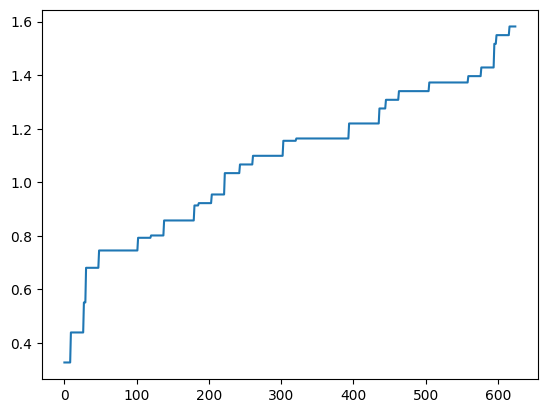

In [14]:
# Using results of brute force optimization as settings
import matplotlib.pyplot as plt

metric = np.array([d["metric"] for d in data])
plt.plot(metric)
print(data[0]["settings"])
interface = MaterialInterface(substrate_for_brute_force, material_for_brute_force, data[0]["settings"])
interface.view(repeat=(2, 2, 1))
